In [1]:
# Download NEREL from GitHub repo
!git lfs install
!git clone https://github.com/nerel-ds/NEREL.git

Git LFS initialized.
Cloning into 'NEREL'...
remote: Enumerating objects: 3071, done.
remote: Counting objects: 100% (3071/3071), done.
remote: Compressing objects: 100% (2889/2889), done.
remote: Total 3071 (delta 1155), reused 2072 (delta 179), pack-reused 0
Receiving objects: 100% (3071/3071), 3.23 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (1155/1155), done.


In [2]:
# Install required modules
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=4671c7c3d90ae5f4aad8ef56d5dcd9bf93d6dda558debe57307e472aac6ad210
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 10.0 MB/s eta 0:00:00


In [3]:
# Useful imports
import random
from typing import List, Optional

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import pymorphy2

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")
nltk.download("omw-1.4")

def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [41]:
class Sentence_graph:
    # Creates graph based on data
    def __init__(self):
        self.path = "/content/NEREL/NEREL-v1.1/"
        self.entities = []
        self.relations = []
        self._parse_annotation()
        self.graph = nx.Graph([])

    def _parse_annotation(self):
        self.entities = []
        self.relations = []
        with open(self.path+"annotation.conf", "r") as f:
            entities = False
            relations = False
            for line in f:
                # print(line)
                if line.isspace():
                    pass
                elif "entities" in line:
                    entities = True
                elif "relations" in line:
                    relations = True
                    entities = False
                elif "[" in line or line[0] == "<":
                    entities = False
                    relations = False
                elif entities:
                    self.entities.append(line.split("\t")[0].split("\n")[0])
                elif relations:
                    self.relations.append(line.split("\t")[0].split("\n")[0])
        # print(self.entities)

    def preprocess_line(self, line):
        sentence = sent_tokenize(line, language="russian")[0]
        length = len(sentence)
        return self.preprocess_sentence(sentence), length

    def preprocess_sentence(self, sentence):
        # Preparation of tools
        stop_words = set(stopwords.words('russian'))
        morph = pymorphy2.MorphAnalyzer()

        # Remove punctuation
        no_punct = sentence.translate(str.maketrans("", "", '.,?!\|/<>:;"^()[]{}'))

        # Create tokens
        word_tokens = word_tokenize(no_punct)

        # Convert the words in word_tokens to lower case
        # Check whether they are present in stop_words or not
        # Lemmatize the present ones
        l = [morph.parse(w.lower())[0].normal_form for w in word_tokens if not w.lower() in stop_words]

        return l

    def parse_text_annotation(self, length, path="test/1130"):
        entities_ann = []
        rels_ann = []
        with open(self.path+path+".ann", "r") as f:
            for line in f:
                if line[0] == 'T':
                    # Entitiy
                    # <id>\t<type> <start> <stop>\t<text>
                    _, body, text = line.split("\t")
                    t, start, stop = body.split(" ")
                    words = self.preprocess_sentence(text)
                    start, stop = int(start), int(stop)

                    if stop >= length:
                        # Not in the sentence
                        continue

                    entities_ann.append([t, words])

                elif line[0] == 'R':
                    # Relation
                    # <id>\t<type> Arg1:<arg1_id> Arg2:<arg2_id>
                    # print(line.split("\t"))
                    _, body, _ = line.split("\t")
                    t, arg1, arg2 = body.split(" ")
                    arg1 = int(arg1.split(":")[1][1:]) - 1
                    arg2 = int(arg2.split(":")[1][1:]) - 1

                    if len(entities_ann) <= arg2 or len(entities_ann) <= arg1:
                        # Not all entities are in the sentence
                        continue
                    rels_ann.append([t, arg1, arg2])
        return entities_ann, rels_ann


    def parse_sentence(self, ex_path="test/1130"):
        sentence = []
        sent_len = 0
        with open(self.path+ex_path+".txt", "r") as f:
            for line in f:
                print(line)
                sentence, sent_len = self.preprocess_line(line)
                if len(sentence) >= 1:
                    break
        if len(sentence) < 1:
            print("No sentences were found")
            return

        entities_ann, rels_ann = self.parse_text_annotation(sent_len, ex_path)

        edge_list = []
        # [ ("Marge", "Homer", {"relation_type": "Married"}) ]

        node_list = {w:{"node_type":[]} for w in list(set(sentence))}
        # "Marge": {"node_type": "Adult"},

        # Add edges for near words
        for w in range(len(sentence)-1):
            edge_list.append((sentence[w], sentence[w+1], {"relation_type": "Near position"}))

        # print(entities_ann)
        for t, words in entities_ann:
            for w in range(len(words)):
                # Add node type to the nodes

                word = words[w]
                if word not in node_list.keys():
                    node_list[word] = {"node_type": [t]}
                    # print(word)
                else:
                    node_list[word]["node_type"].append(t)

                for other in words[w+1:]:
                    edge_list.append((word, other, {"relation_type": t}))

        # print(rels_ann)
        for t, ind1, ind2 in rels_ann:

            words1 = entities_ann[ind1][1]
            words2 = entities_ann[ind2][1]

            for w1 in entities_ann[ind1][1]:
                for w2 in entities_ann[ind2][1]:
                    edge_list.append((w1, w2, {"relation_type": t}))



        self.graph = nx.Graph(edge_list)
        nx.set_node_attributes(self.graph, node_list)

        G = self.graph

        pos = nx.spring_layout(G)
        edge_labels = nx.get_edge_attributes(G, "relation_type")

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
        ax.set_axis_off()
        ax = fig.add_subplot(1, 1, 1)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
        nx.draw_networkx(G, ax=ax, pos=pos, node_size=1000, with_labels=True)
        plt.axis("off")
        plt.show()

        print("All nodes with attributes\n")
        for node, attr in self.graph.nodes.data():
            print(f"{node} \t", end="")
            for k in attr.keys():
                v= attr[k]
                if len(v)==0:
                    continue
                print(f"{k}: ", end="")
                for i in v[:-1]:
                    print(f"{v}, ", end="")
                print(f"{v[-1]} ", end="")
            print()

        print("\n\nAll edges with attributes\n")
        for node1, node2, attr in self.graph.edges.data():
            print(f"{node1} - {node2} \t", end="")
            for k in attr.keys():
                print(f"{k}: {attr[k]}", end=" ")
            print()







Словацкий тренер Жолт Хорняк возглавил "Бананц" (Ереван)



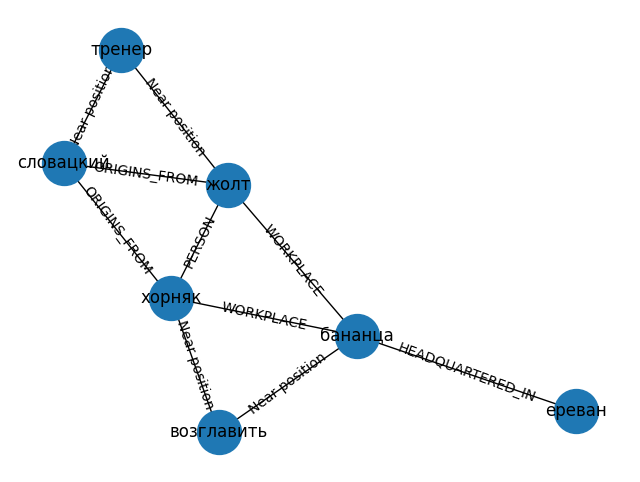

All nodes with attributes

словацкий 	node_type: NATIONALITY 
тренер 	node_type: PROFESSION 
жолт 	node_type: PERSON 
хорняк 	node_type: PERSON 
возглавить 	node_type: EVENT 
бананца 	node_type: ORGANIZATION 
ереван 	node_type: CITY 


All edges with attributes

словацкий - тренер 	relation_type: Near position 
словацкий - жолт 	relation_type: ORIGINS_FROM 
словацкий - хорняк 	relation_type: ORIGINS_FROM 
тренер - жолт 	relation_type: Near position 
жолт - хорняк 	relation_type: PERSON 
жолт - бананца 	relation_type: WORKPLACE 
хорняк - возглавить 	relation_type: Near position 
хорняк - бананца 	relation_type: WORKPLACE 
возглавить - бананца 	relation_type: Near position 
бананца - ереван 	relation_type: HEADQUARTERED_IN 


In [44]:
gr = Sentence_graph()
gr.parse_sentence(ex_path="test/1130")

Used resources:

https://networkx.org/documentation/stable/tutorial.html

https://python-school.ru/blog/nlp-text-preprocessing/

https://github.com/ridgerchu/SpikeGPT/blob/master/src/utils.py

https://huggingface.co/datasets/iluvvatar/NEREL

@article{loukachevitch2021nerel,
title={NEREL: A Russian Dataset with Nested Named Entities, Relations and Events},
author={Loukachevitch, Natalia and Artemova, Ekaterina and Batura, Tatiana and Braslavski, Pavel and Denisov, Ilia and Ivanov, Vladimir and Manandhar, Suresh and Pugachev, Alexander and Tutubalina, Elena},
journal={arXiv preprint arXiv:2108.13112},
year={2021}
}

https://github.com/nerel-ds/NEREL/tree/master

https://arxiv.org/pdf/2205.02767.pdf

https://arxiv.org/pdf/2006.15437.pdf